## 1. パラメトリック固有空間法の実装と検証
1. **目的**: パラメトリック固有空間法を実装し、以下を検討する。
    - 位置や姿勢、文字種、傾き、文字の太さなどのパラメータについて、真値をどの程度正確に推定できるか。
    - 必要な教師信号の数を推定する。
パラメトリック固有空間法を実装する。位置・姿勢 / 文字種と傾きと文字の太さ。真値をどの程度正しく推定できるであろうか。教師となる信号はどのくらいの数を必要とするであろうか。

まず，画像を生成する関数を作成する．
今回は，25×25の画像を生成する．

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from scipy.ndimage import zoom
# 日本語フォントを設定
matplotlib.rcParams['font.family'] = 'Meiryo'


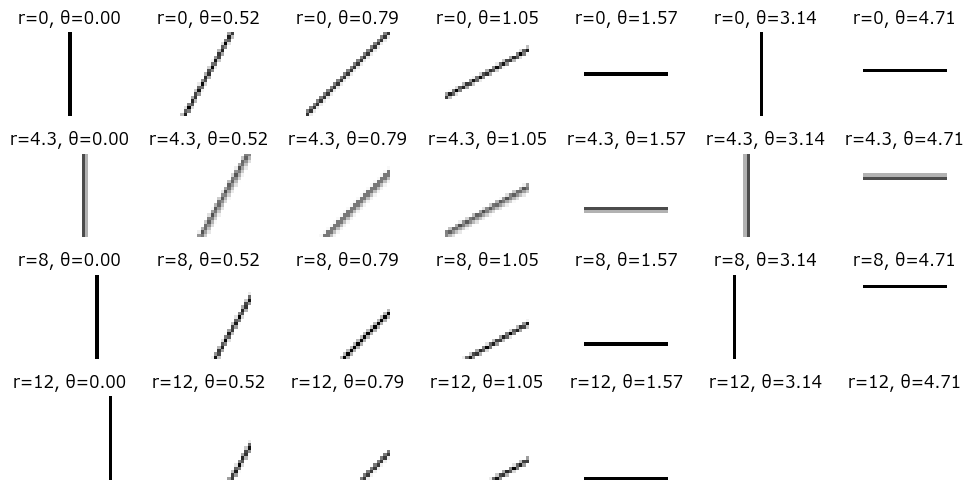

In [2]:
def generate_image(r, theta):
    # 49x49の真っ白な画像を生成（255: 白, 0: 黒）
    img_size = 49
    large_img = np.full((img_size, img_size), 255, dtype=np.uint8)
    # 中央に縦線を描く（黒: 0）
    center = img_size // 2
    large_img[:, center] = 0
    # 並進処理
    int_r = int(np.floor(r))  # rの整数部分
    frac_r = r - int_r        # rの小数部分
    # 並進画像を2つ生成
    shifted_img1 = np.roll(large_img, shift=int_r, axis=1)       # int(r)分の並進
    shifted_img2 = np.roll(large_img, shift=int_r + 1, axis=1)   # int(r) + 1分の並進
    # 重みを用いて内分
    large_img = (1 - frac_r) * shifted_img1 + frac_r * shifted_img2
    large_img = large_img.astype(np.uint8)  # 整数型に変換
    # 回転処理
    img = Image.fromarray(large_img)
    img = img.rotate(-np.degrees(theta), resample=Image.BILINEAR, center=(center, center))
    # 回転後の画像をnumpy配列に変換
    rotated_img = np.array(img)
    # 中央の25x25マスを切り抜き
    small_center = img_size // 2
    output_size = 25
    start = small_center - output_size // 2
    end = start + output_size
    small_img = rotated_img[start:end, start:end]\
    
    return small_img


# 確認用の画像を出力
def visualize_results():
    r_values = [0, 4.3, 8, 12]
    theta_values = [0, np.pi/6, np.pi/4, np.pi/3, np.pi/2, np.pi, 3*np.pi/2]
    fig, axes = plt.subplots(len(r_values), len(theta_values), figsize=(10, 5))
    for i, r in enumerate(r_values):
        for j, theta in enumerate(theta_values):
            img = generate_image(r, theta)
            axes[i, j].imshow(img, cmap='gray', vmin=0, vmax=255)
            axes[i, j].axis('off')
            axes[i, j].set_title(f"r={r}, θ={theta:.2f}")
    plt.tight_layout()
    plt.show()

# 結果を可視化
visualize_results()


画像を生成するプログラムとは別に画像ベクトルを生成するプログラムを作成する．


In [3]:
def generate_dataset(r, theta):
    # 49x49の真っ白な画像を生成（255: 白, 0: 黒）
    img_size = 49
    large_img = np.full((img_size, img_size), 255, dtype=np.uint8)
    # 中央に縦線を描く（黒: 0）
    center = img_size // 2
    large_img[:, center] = 0
    # 並進処理
    int_r = int(np.floor(r))  # rの整数部分
    frac_r = r - int_r        # rの小数部分
    # 並進画像を2つ生成
    shifted_img1 = np.roll(large_img, shift=int_r, axis=1)       # int(r)分の並進
    shifted_img2 = np.roll(large_img, shift=int_r + 1, axis=1)   # int(r) + 1分の並進
    # 重みを用いて内分
    large_img = (1 - frac_r) * shifted_img1 + frac_r * shifted_img2
    large_img = large_img.astype(np.uint8)  # 整数型に変換
    # 回転処理
    img = Image.fromarray(large_img)
    img = img.rotate(-np.degrees(theta), resample=Image.BILINEAR, center=(center, center))
    # 回転後の画像をnumpy配列に変換
    rotated_img = np.array(img)
    # 中央の25x25マスを切り抜き
    small_center = img_size // 2
    output_size = 25
    start = small_center - output_size // 2
    end = start + output_size
    small_img = rotated_img[start:end, start:end]
    return small_img.flatten()

# データセットimage_vectorsを生成　0~12のr0.3刻み，0~2πのπ/60刻み
r_values = np.arange(0, 12.1, 1/3)
theta_values = np.arange(0, 2*np.pi, np.pi/20)
image_vectors = []
for r in r_values:
    for theta in theta_values:
        img = generate_dataset(r, theta)
        image_vectors.append(img)
image_vectors = np.array(image_vectors)


共分散行列を計算し，固有値分解を行う．

In [4]:
covarience_matrix = np.zeros((625, 625))
for vector in image_vectors:
    normalized_vector = vector - np.mean(image_vectors, axis=0)
    covarience_matrix += np.outer(normalized_vector, normalized_vector)
eigen_values, eigen_vectors = np.linalg.eigh(covarience_matrix)
sorted_indices = np.argsort(eigen_values)[::-1]
sorted_eigen_values = eigen_values[sorted_indices]
sorted_eigen_vectors = eigen_vectors[:, sorted_indices]

top_10_eigen_vectors = sorted_eigen_vectors[:, :10].T


(10, 625)


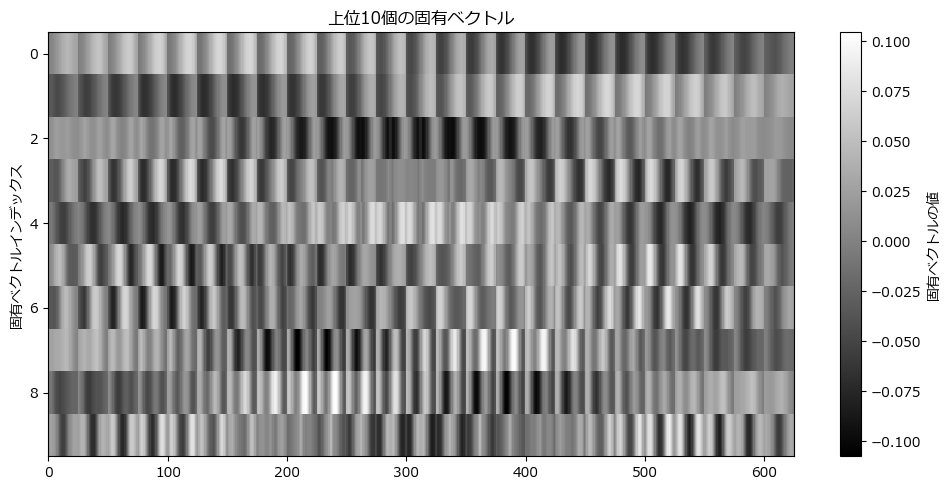

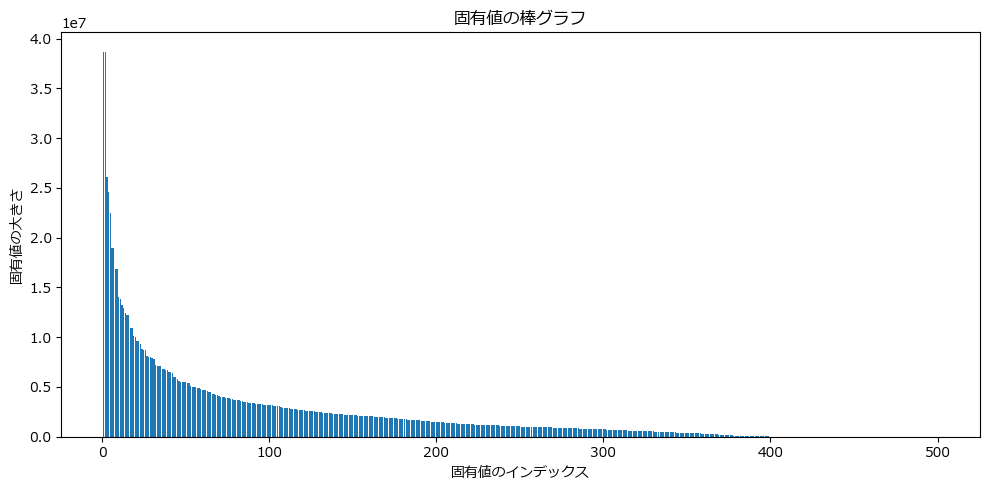

In [5]:
print(top_10_eigen_vectors.shape)
# 固有ベクトルを画像に変換
plt.figure(figsize=(10, 5))
plt.imshow(top_10_eigen_vectors, cmap='gray', aspect='auto', interpolation='nearest')
plt.title("上位10個の固有ベクトル")
plt.ylabel("固有ベクトルインデックス")
plt.colorbar(label="固有ベクトルの値")
plt.tight_layout()
plt.show()

# 固有値を棒グラフで可視化
plt.figure(figsize=(10, 5))
plt.bar(np.arange(1, 500+1), sorted_eigen_values[:500])
plt.title("固有値の棒グラフ")
plt.xlabel("固有値のインデックス")
plt.ylabel("固有値の大きさ")
plt.tight_layout()
plt.show()

上位3つの固有ベクトルを取得し，固有空間を構築する．
その固有空間に画像を射影しプロットする．

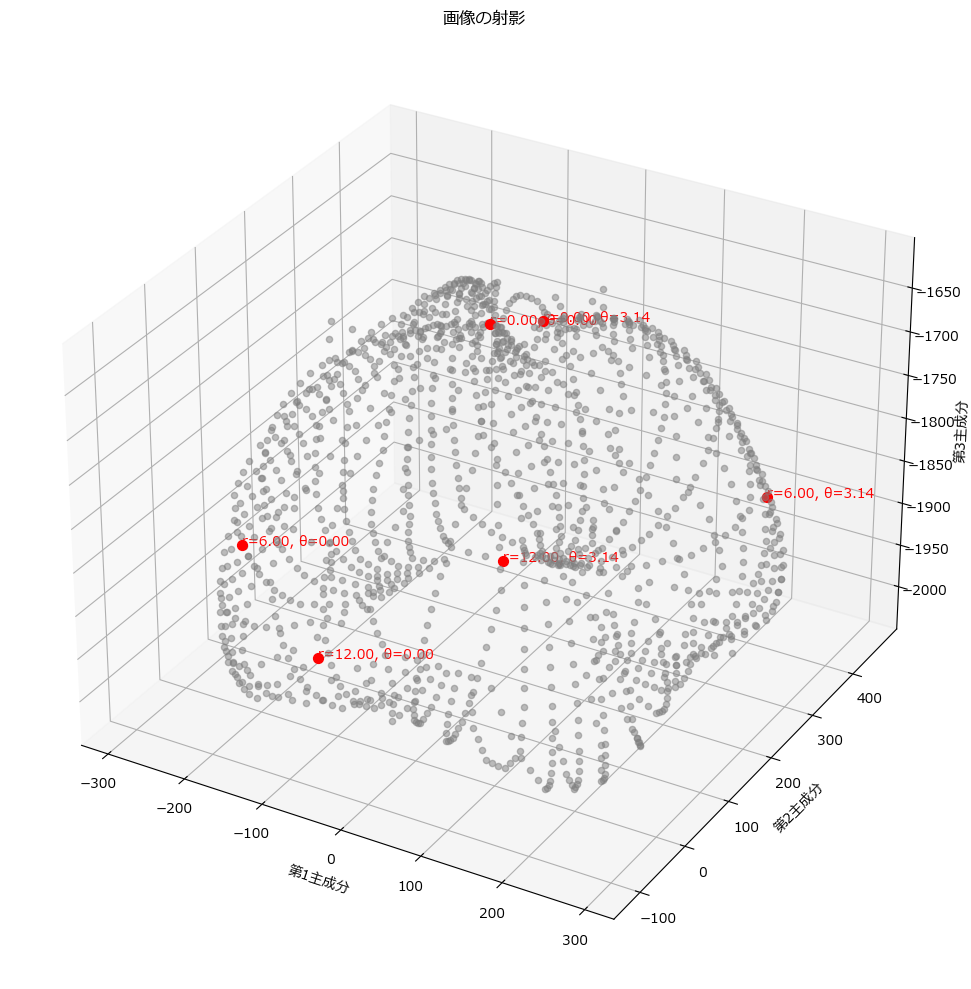

In [6]:
# 上位3つの固有ベクトルを用いて固有空間を張り，画像を射影しプロット
def project_image(img, basis_vectors):
    return np.array([np.dot(img, v) for v in basis_vectors])

v1, v2, v3 = top_10_eigen_vectors[:3]
basis_vectors = np.array([v1, v2, v3])

# 画像を射影
proj_vectors = np.array([project_image(img, basis_vectors) for img in image_vectors])

# 主要なプロット条件
highlight_r_values = [0, 6, 12]
highlight_theta_values = [np.pi * i / 3 for i in range(6)]

# r_values と theta_values の直積を作成
all_r_theta_combinations = [(r, theta) for r in r_values for theta in theta_values]
# 3次元空間に射影した結果をプロット:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# グレーの点を先にプロット
for i, (r, theta) in enumerate(all_r_theta_combinations):
    x, y, z = proj_vectors[i]
    if not (r in highlight_r_values and any(np.isclose(theta, major_theta) for major_theta in highlight_theta_values)):
        ax.scatter(x, y, z, c='gray', marker='o', alpha=0.5)  # グレーの点

# 赤点を後にプロット
for i, (r, theta) in enumerate(all_r_theta_combinations):
    x, y, z = proj_vectors[i]
    if r in highlight_r_values and any(np.isclose(theta, major_theta) for major_theta in highlight_theta_values):
        ax.scatter(x, y, z, c='r', marker='o', s=50)  # 赤色で主要プロット
        ax.text(x, y, z, f"r={r:.2f}, θ={theta:.2f}", color='red')  # 赤色のラベル
ax.set_xlabel('第1主成分')
ax.set_ylabel('第2主成分')
ax.set_zlabel('第3主成分')
plt.title("画像の射影")
plt.tight_layout()
plt.show()

真の値: r=4.38, θ=0.56
推定値: r=4.00, θ=0.63


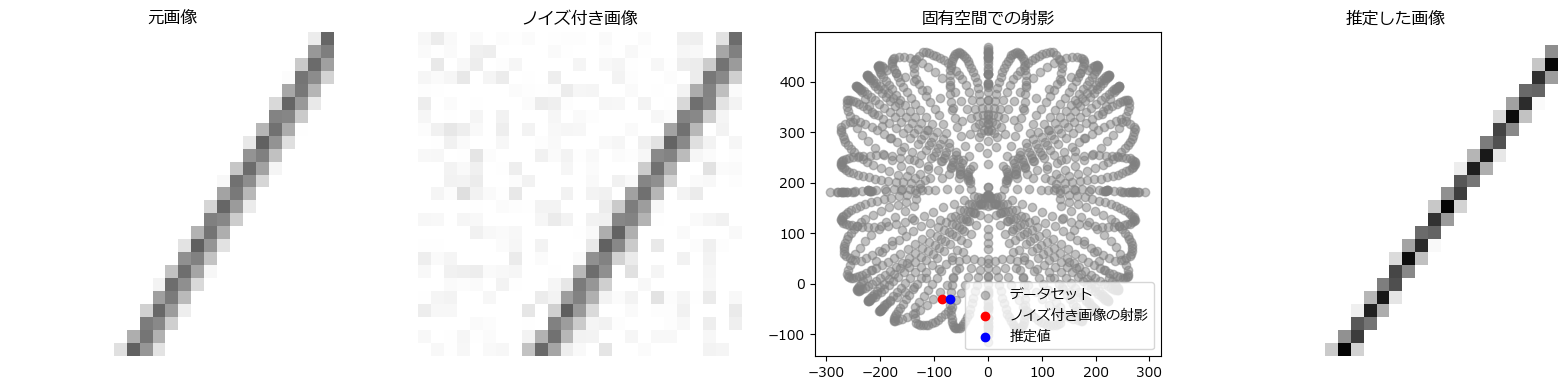

In [16]:
import random
from scipy.spatial.distance import cdist


def add_noise(image, noise_level=10):
    """画像にランダムなノイズを追加する関数"""
    noisy_image = image + np.random.normal(0, noise_level, image.shape)
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

# ランダムにrとθを生成


def random_r_theta():
    r = random.uniform(0, 12)
    theta = random.uniform(0, 2 * np.pi)
    return r, theta

# 生成した画像を固有空間に射影し最近点を探索


def find_nearest_point(noisy_projection, projected_dataset):
    """射影されたノイズ付き画像から最近の点を探索"""
    distances = cdist([noisy_projection], projected_dataset)
    nearest_index = np.argmin(distances)
    return nearest_index


# 真値推定を実施
r_true, theta_true = random_r_theta()
original_image = generate_image(r_true, theta_true)
noisy_image = add_noise(original_image)

# 画像をベクトル化し固有空間に射影
noisy_image_vector = noisy_image.flatten()
noisy_projection = project_image(noisy_image_vector, basis_vectors)

# 最近点を探索
nearest_index = find_nearest_point(noisy_projection, proj_vectors)
nearest_r, nearest_theta = all_r_theta_combinations[nearest_index]

# 結果を表示
print(f"真の値: r={r_true:.2f}, θ={theta_true:.2f}")
print(f"推定値: r={nearest_r:.2f}, θ={nearest_theta:.2f}")

# 推定した画像を生成
estimated_image = generate_image(nearest_r, nearest_theta)

# 可視化
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(original_image, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("元画像")
axes[0].axis('off')

axes[1].imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("ノイズ付き画像")
axes[1].axis('off')

axes[2].scatter(proj_vectors[:, 0], proj_vectors[:, 1], c='gray', alpha=0.5, label='データセット')
axes[2].scatter(noisy_projection[0], noisy_projection[1], c='red', label='ノイズ付き画像の射影')
axes[2].scatter(proj_vectors[nearest_index, 0], proj_vectors[nearest_index, 1], c='blue', label='推定値')
axes[2].legend()
axes[2].set_title("固有空間での射影")

axes[3].imshow(estimated_image, cmap='gray', vmin=0, vmax=255)
axes[3].set_title("推定した画像")
axes[3].axis('off')

plt.tight_layout()
plt.show()

SN比（Signal-to-Noise Ratio, SNR）は、信号の強度とノイズの強度の比率を示し、通常はデシベル（dB）単位で表されます。以下の式で表されます：

### SN比の式

#### リニアスケールでの定義
\[
\text{SNR} = \frac{P_{\text{signal}}}{P_{\text{noise}}}
\]
ここで：
- \( P_{\text{signal}} \) は信号のパワー
- \( P_{\text{noise}} \) はノイズのパワー

#### デシベルスケールでの定義
\[
\text{SNR}_{\text{dB}} = 10 \cdot \log_{10}\left(\frac{P_{\text{signal}}}{P_{\text{noise}}}\right)
\]

### 例
- 高いSN比（たとえば30dB）は、信号がノイズよりもかなり強いことを意味します。
- 低いSN比（たとえば0dB）は、信号とノイズが同程度の強さであることを意味します。

この定義を基に、ノイズの強度とSN比の関係を評価することができます。

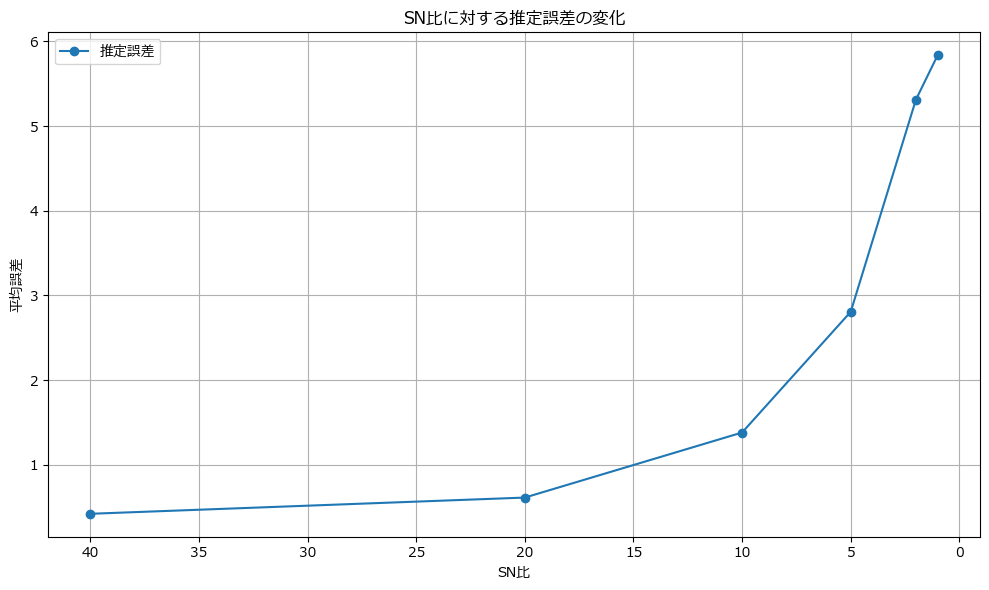

In [17]:
import random
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np


def add_noise(image, noise_level=10):
    """画像にランダムなノイズを追加する関数"""
    noisy_image = image + np.random.normal(0, noise_level, image.shape)
    return np.clip(noisy_image, 0, 255).astype(np.uint8)


def random_r_theta():
    """ランダムにrとθを生成"""
    r = random.uniform(0, 12)
    theta = random.uniform(0, 2 * np.pi)
    return r, theta


def find_nearest_point(noisy_projection, projected_dataset):
    """射影されたノイズ付き画像から最近の点を探索"""
    distances = cdist([noisy_projection], projected_dataset)
    nearest_index = np.argmin(distances)
    return nearest_index


def evaluate_sn_ratio_performance(noise_levels, num_trials=50):
    """SN比に対する推定精度を評価"""
    errors = []
    for noise_level in noise_levels:
        total_error = 0
        for _ in range(num_trials):
            # ランダムなrとθを生成
            r_true, theta_true = random_r_theta()
            original_image = generate_image(r_true, theta_true)
            noisy_image = add_noise(original_image, noise_level=noise_level)

            # 画像をベクトル化し固有空間に射影
            noisy_image_vector = noisy_image.flatten()
            noisy_projection = project_image(noisy_image_vector, basis_vectors)

            # 最近点を探索
            nearest_index = find_nearest_point(noisy_projection, proj_vectors)
            nearest_r, nearest_theta = all_r_theta_combinations[nearest_index]

            # 真値との誤差を計算
            error = np.sqrt((r_true - nearest_r)**2 +
                            (theta_true - nearest_theta)**2)
            total_error += error

        # 平均誤差を記録
        mean_error = total_error / num_trials
        errors.append(mean_error)
    return errors


# SN比に対応するノイズレベルを定義
sn_ratios = [40, 20, 10, 5, 2, 1]  # SN比を仮定
noise_levels = [255 / ratio for ratio in sn_ratios]

# SN比ごとの誤差を計算
errors = evaluate_sn_ratio_performance(noise_levels)

# グラフの描画
plt.figure(figsize=(10, 6))
plt.plot(sn_ratios, errors, marker='o', label='推定誤差')
plt.gca().invert_xaxis()  # SN比が高い方が左に来るように反転
plt.xlabel("SN比")
plt.ylabel("平均誤差")
plt.title("SN比に対する推定誤差の変化")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()